<a href="https://colab.research.google.com/github/ghazalna/Credit_Card_Transactions_Fraud_Detection/blob/main/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection Dataset**

In [1]:
from google.colab import files

In [2]:
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
df= pd.read_csv('creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [27]:
import numpy as np

invalid_indices = np.where(X_train < 0)
print(invalid_indices)


(array([     0,      0,      0, ..., 227844, 227844, 227844]), array([ 2,  3,  4, ..., 23, 25, 29]))


# **Split Data**

In [7]:
X = df.drop(columns=['Class'])
y = df['Class']

In [8]:
#Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(227845, 30) (227845,) (56962, 30) (56962,)


In [11]:
# X_train
np.unique(y_train)

array([0, 1])

In [12]:
y_test

,Class
263020,0
11378,0
147283,0
219439,0
36939,0
...,...
54199,0
184616,0
274532,0
269819,0


# **Hyperparameters**

In [19]:
X_train.shape

(227845, 30)

In [37]:
maxlen = X_train.shape[1]  # Based on the input data
vocab_size = maxlen
X_train[X_train >= vocab_size] = vocab_size - 1
X_train[X_train < 0] = 0
embed_dim = 64
num_heads = 8
ff_dim = 128
dropout_rate = 0.1

In [38]:
invalid_indices = np.where((X_train >= vocab_size) | (X_train < 0))
print(invalid_indices)


(array([], dtype=int64), array([], dtype=int64))


In [39]:
maxlen

30

In [40]:
vocab_size = 30  # Based on the initial assumption
invalid_indices = np.where(X_train >= vocab_size)
print(invalid_indices)  # This will give you the positions of any invalid indices


(array([], dtype=int64), array([], dtype=int64))


# **Model**

In [41]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [42]:
def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
  attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
  attn_output = Dropout(rate)(attn_output)
  out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

  ffn_output = Dense(ff_dim, activation='relu')(out1)
  ffn_output = Dense(embed_dim)(ffn_output)
  ffn_output = Dropout(rate)(ffn_output)
  return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

In [43]:
def build_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim):
  inputs = Input(shape=(maxlen,))
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
  pos_encoding = positional_encoding(maxlen, embed_dim)
  x = embedding_layer + pos_encoding

  x = transformer_block(x, embed_dim, num_heads, ff_dim)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  outputs = Dense(1, activation='sigmoid')(x)  #binary classification - output layer=1. # Single output unit for binary classification

  model = Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy",
                metrics = ['accuracy'])
  return model

In [44]:
model = build_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 30)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 30, 64)         │          1,920 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 30, 64)         │              0 │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 30, 64)         │        132,672 │ add_9[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_9[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 30, 64)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 30, 64)         │              0 │ add_9[0][0],           │
│                           │                        │                │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 30, 64)         │            128 │ add_10[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 30, 128)        │          8,320 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 30, 64)         │          8,256 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 30, 64)         │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 30, 64)         │              0 │ layer_normalization_6… │
│                           │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 30, 64)         │            128 │ add_11[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ layer_normalization_7… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 64)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │          4,160 │ dropout_18[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_19 (Dropout)      │ (None, 64)             │              0 │ dense_14[0][0]         │
├──────────────────────

 Total params: 155,649 (608.00 KB)

 Trainable params: 155,649 (608.00 KB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [45]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 249s 43ms/step - accuracy: 0.9918 - loss: 0.0259 - val_accuracy: 0.9982 - val_loss: 0.0086
Epoch 2/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 261s 43ms/step - accuracy: 0.9984 - loss: 0.0078 - val_accuracy: 0.9988 - val_loss: 0.0064
Epoch 3/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 246s 43ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.9992 - val_loss: 0.0049
Epoch 4/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 260s 43ms/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.9993 - val_loss: 0.0048
Epoch 5/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 261s 43ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 6/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 263s 43ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9990 - val_loss: 0.0054
Epoch 7/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 263s 43ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9991 - val_loss: 0.0051
Epoch 8/20
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 244s 43ms/step - accuracy: 

# **Model evaluation**

In [50]:
import numpy as np

vocab_size = 30  # Make sure this matches your model's embedding layer input_dim
invalid_indices = np.where(X_test >= vocab_size)
print("Invalid indices:", invalid_indices)


Invalid indices: (array([], dtype=int64), array([], dtype=int64))


In [51]:
X_test_clipped = np.clip(X_test, 0, vocab_size - 1)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.71      0.78        98

    accuracy                           1.00     56962
   macro avg       0.93      0.86      0.89     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9653925441870614


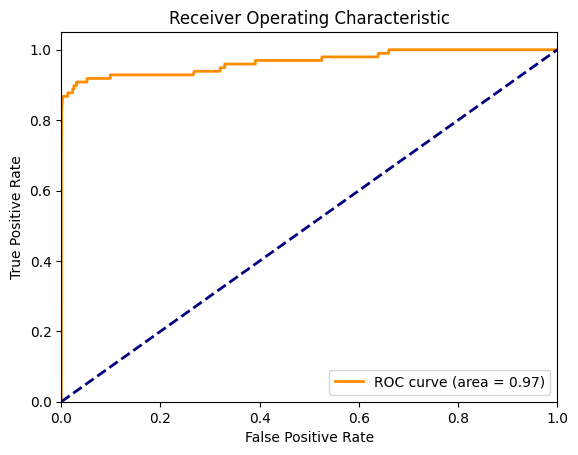

In [52]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Prediction
y_pred = model.predict(X_test_clipped)  # Use the corrected X_test
y_pred_classes = (y_pred > 0.5).astype(int)



# Classification Report
print(classification_report(y_test, y_pred_classes))

# ROC-AUC Score
if len(y_test.shape) == 1 or y_test.shape[1] == 1:  # Handle binary case
    print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))
else:
    print("ROC-AUC Score (macro):", roc_auc_score(y_test, y_pred, average='macro'))
    print("ROC-AUC Score (micro):", roc_auc_score(y_test, y_pred, average='micro'))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())  # Using .ravel() for binary case
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
